<a href="https://colab.research.google.com/github/hoangDEVteams/deeplearning/blob/main/animal10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import file kaglle.json để tải dữ liệu dataset từ kaggle

In [ ]:
from google.colab import files
# Cài đặt Kaggle API
!pip install -q kaggle
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hoanglearning","key":"139107b7e925ade6c0a1bdd6e66865c6"}'}

đây là file cấu hình của kaggle dùng để tải dataset

In [1]:
import os

# Tạo thư mục ~/.kaggle nếu chưa có
os.makedirs("/root/.kaggle", exist_ok=True)

# Di chuyển file kaggle.json vào thư mục ~/.kaggle
!mv kaggle.json /root/.kaggle/

# Đặt quyền truy cập (bắt buộc để tránh lỗi)
!chmod 600 /root/.kaggle/kaggle.json


mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


tải dataset từ kaggle

In [2]:
!kaggle datasets download -d alessiocorrado99/animals10

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
100% 583M/586M [00:26<00:00, 24.8MB/s]
100% 586M/586M [00:26<00:00, 23.0MB/s]


In [3]:
import zipfile

# Giải nén file ZIP
with zipfile.ZipFile("animals10.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/data")

print("✅ Giải nén thành công!")

✅ Giải nén thành công!


kiểm tra dữ liệu

In [4]:
import os
print(os.listdir("/content/data"))

['translate.py', 'raw-img']


In [33]:
import glob

image_paths = glob.glob("/content/data/**/*.jpg", recursive=True)  # Lấy tất cả file .jpg
print(f"📸 Tìm thấy {len(image_paths)} ảnh trong dataset.")
print("📜 Một số đường dẫn ảnh:")
print("\n".join(image_paths[:5]))  # In 5 ảnh đầu tiên


📸 Tìm thấy 1919 ảnh trong dataset.
📜 Một số đường dẫn ảnh:
/content/data/raw-img/farfalla/eb31b20e2cfd033ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.jpg
/content/data/raw-img/farfalla/ea37b00e29f0093ed1584d05fb1d4e9fe777ead218ac104497f5c97faeebb5bb_640.jpg
/content/data/raw-img/farfalla/ea36b7072ff0003ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg
/content/data/raw-img/farfalla/ea36b90c2cf3053ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg
/content/data/raw-img/farfalla/e837b3072ef7083ed1584d05fb1d4e9fe777ead218ac104497f5c97faee9bdba_640.jpg


Xử lý dữ liệu

chia data

In [43]:
!pip install split-folders tqdm
import splitfolders

# Đường dẫn thư mục gốc
dataset_dir = "/content/data/raw-img"
output_dir = "/content/data/valid_data"  # Thư mục sau khi chia

# Chia 80% train, 20% test
splitfolders.ratio(dataset_dir, output=output_dir, seed=42, ratio=(0.8, 0.1,0.1), group_prefix=None)


Copying files: 26179 files [00:07, 3310.06 files/s]


Bạn cần chia dataset thành 3 phần để huấn luyện và đánh giá mô hình:

Train set (~70-80%): Dùng để huấn luyện.

Validation set (~10-15%): Dùng để tối ưu mô hình, tránh overfitting.


Test set (~10-15%): Đánh giá mô hình sau khi train.

In [62]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Định nghĩa các đường dẫn
dataset_dir = "/content/data/valid_data/"
img_size = 64  # Resize ảnh
batch_size = 64

# Tạo ImageDataGenerator cho train và validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    shear_range=0.15,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load dữ liệu train
train_generator = train_datagen.flow_from_directory(
    dataset_dir + "train",  # Không dùng subset
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical",
    seed=42
)
# Tạo riêng datagen cho validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Load dữ liệu validation
val_generator = val_datagen.flow_from_directory(
    dataset_dir + "val",
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    dataset_dir+"test", # Thư mục chứa ảnh test
    target_size=(img_size,img_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False  # Không shuffle để giữ thứ tự file ảnh
)


Found 20938 images belonging to 10 classes.
Found 5241 images belonging to 10 classes.
Found 2627 images belonging to 10 classes.


In [64]:
from sklearn.utils import class_weight
import numpy as np

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)
class_weights_dict = dict(enumerate(class_weights))

model.fit(train_generator, validation_data=val_generator, class_weight=class_weights_dict, epochs=10)


Epoch 1/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 65s 199ms/step - accuracy: 0.7394 - loss: 0.8667 - val_accuracy: 0.6394 - val_loss: 1.2175
Epoch 2/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 69s 212ms/step - accuracy: 0.7522 - loss: 0.8198 - val_accuracy: 0.5833 - val_loss: 1.4820
Epoch 3/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 67s 203ms/step - accuracy: 0.7589 - loss: 0.7942 - val_accuracy: 0.5800 - val_loss: 1.5107
Epoch 4/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 69s 211ms/step - accuracy: 0.7641 - loss: 0.7586 - val_accuracy: 0.6020 - val_loss: 1.4299
Epoch 5/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 67s 206ms/step - accuracy: 0.7737 - loss: 0.7344 - val_accuracy: 0.6802 - val_loss: 1.1366
Epoch 6/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 68s 206ms/step - accuracy: 0.7792 - loss: 0.7023 - val_accuracy: 0.6482 - val_loss: 1.2351
Epoch 7/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 68s 207ms/step - accuracy: 0.7870 - loss: 0.6952 - val_accuracy: 0.6531 - val_loss: 1.1759
Epoch 8/10
328/328 ━━━━━━━━━━━━━━━━━━━━ 67s 204ms/step - accuracy: 0.7943 - loss: 0

mô hình CNN

In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [65]:
model = Sequential([
    Input(shape=(img_size, img_size, 3)),

    Conv2D(64, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),  # Chỉ dùng 3 lần pooling để tránh kích thước âm

    Conv2D(384, (3,3), padding='same', activation='relu'),  # Giảm số filters
    BatchNormalization(),

    GlobalAveragePooling2D(),  # Giữ nguyên

    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
    BatchNormalization(),
    Dropout(0.5),

    Dense(10, activation='softmax')
])
# Compile model
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=0.0003),
    metrics=['accuracy']
)

# Callback giảm learning rate khi loss không giảm nữa
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Hiển thị cấu trúc model
model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)                   │ (None, 64, 64, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_48               │ (None, 64, 64, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_26 (MaxPooling2D)      │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_33 (Conv2D)                   │ (None, 32, 32, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_49               │ (None, 32, 32, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_27 (MaxPooling2D)      │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_34 (Conv2D)                   │ (None, 16, 16, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_50               │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_28 (MaxPooling2D)      │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_35 (Conv2D)                   │ (None, 8, 8, 384)           │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_51               │ (None, 8, 8, 384)           │           1,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_8           │ (None, 384)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ (None, 256)                 │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_52               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_53               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 256)                 │              

 Total params: 1,428,234 (5.45 MB)

 Trainable params: 1,425,546 (5.44 MB)

 Non-trainable params: 2,688 (10.50 KB)

dự đoán độ chính xác của mô hình

In [66]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Đường dẫn ảnh cần dự đoán
img_path = "/content/data/raw-img/cane/OIF-e2bexWrojgtQnAPPcUfOWQ.jpeg"  # Thay bằng ảnh của bạn

# Load và tiền xử lý ảnh
img = image.load_img(img_path, target_size=(64, 64))  # Resize ảnh
img_array = image.img_to_array(img) / 255.0  # Chuẩn hóa (rescale)
img_array = np.expand_dims(img_array, axis=0)  # Thêm batch dimension

# Dự đoán
pred = model.predict(img_array)
predicted_class = np.argmax(pred)  # Lấy lớp có xác suất cao nhất

# In kết quả
class_indices = train_generator.class_indices  # Lấy danh sách tên lớp
class_names = list(class_indices.keys())  # Đổi thành danh sách

print(f"Dự đoán: {class_names[predicted_class]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
Dự đoán: cane


In [67]:
import numpy as np

# Dự đoán trên tập test
predictions = model.predict(test_generator)

# Lấy nhãn dự đoán
predicted_classes = np.argmax(predictions, axis=1)

# Lấy tên lớp
class_indices = train_generator.class_indices
class_names = list(class_indices.keys())

# In kết quả của 10 ảnh đầu tiên
for i in range(10):
    print(f"Ảnh {i+1}: Dự đoán = {class_names[predicted_classes[i]]}")
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 121ms/step
Ảnh 1: Dự đoán = cane
Ảnh 2: Dự đoán = cane
Ảnh 3: Dự đoán = cane
Ảnh 4: Dự đoán = cane
Ảnh 5: Dự đoán = cane
Ảnh 6: Dự đoán = cane
Ảnh 7: Dự đoán = cane
Ảnh 8: Dự đoán = cane
Ảnh 9: Dự đoán = cane
Ảnh 10: Dự đoán = cane
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - accuracy: 0.4740 - loss: 2.5267
Test Accuracy: 18.54%


In [53]:
import numpy as np
print(np.bincount(train_generator.classes))  # Kiểm tra số ảnh mỗi class


[3890 2098 1156 1689 2478 1334 1492 1456 3856 1489]


epochs trong huấn luyện mô hình deep learning là số lần toàn bộ dataset được đưa qua mô hình trong quá trình huấn luyện.

📌 Giải thích chi tiết:
Khi bạn huấn luyện mô hình, dữ liệu được chia thành nhiều batch (tập nhỏ).

Một epoch là khi mô hình được huấn luyện trên toàn bộ dữ liệu huấn luyện một lần.

Nếu bạn đặt epochs = 20, nghĩa là mô hình sẽ lặp qua toàn bộ dữ liệu 20 lần.

Giả sử bạn có 1.000 ảnh trong dataset và batch_size=32, thì:

Mỗi batch có 32 ảnh.
Số batch mỗi epoch = 1000 / 32 ≈ 31 batch.
Nếu epochs = 20, mô hình sẽ chạy 31 × 20 = 620 batch.

In [17]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    epochs=20,
    validation_steps=len(val_generator)
)

Epoch 1/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 92s 243ms/step - accuracy: 0.1873 - loss: 2.5915 - val_accuracy: 0.2058 - val_loss: 2.5153
Epoch 2/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 72s 221ms/step - accuracy: 0.3228 - loss: 1.9893 - val_accuracy: 0.3041 - val_loss: 1.9171
Epoch 3/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 73s 224ms/step - accuracy: 0.3953 - loss: 1.7523 - val_accuracy: 0.3968 - val_loss: 1.7271
Epoch 4/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 73s 222ms/step - accuracy: 0.4678 - loss: 1.5481 - val_accuracy: 0.3735 - val_loss: 1.8804
Epoch 5/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 82s 249ms/step - accuracy: 0.5234 - loss: 1.3956 - val_accuracy: 0.4977 - val_loss: 1.4852
Epoch 6/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 74s 225ms/step - accuracy: 0.5579 - loss: 1.2943 - val_accuracy: 0.3859 - val_loss: 2.0351
Epoch 7/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 81s 223ms/step - accuracy: 0.5976 - loss: 1.2000 - val_accuracy: 0.5503 - val_loss: 1.3131
Epoch 8/20
328/328 ━━━━━━━━━━━━━━━━━━━━ 81s 220ms/step - accuracy: 0.6230 - loss: 1

In [24]:
from google.colab import files

uploaded = files.upload()  # Hộp thoại sẽ hiện ra cho bạn chọn file

Saving gau.jpg to gau (1).jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


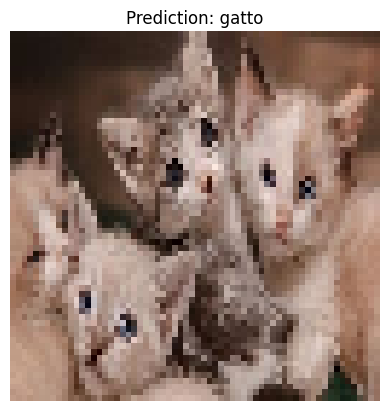

Dự đoán: gatto, Xác suất: 0.5460


In [30]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Lấy danh sách nhãn từ train_generator
class_names = list(train_generator.class_indices.keys())

def predict_image(img_path, model):
    img = image.load_img(img_path, target_size=(64, 64))  # Resize ảnh
    img_array = image.img_to_array(img) / 255.0  # Chuẩn hóa
    img_array = np.expand_dims(img_array, axis=0)  # Thêm batch dimension

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction)  # Lấy nhãn có xác suất cao nhất
    class_name = class_names[predicted_class]  # Tìm tên lớp dự đoán

    # Hiển thị ảnh + dự đoán
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Prediction: {class_name}")
    plt.show()

    print(f"Dự đoán: {class_name}, Xác suất: {max(prediction[0]):.4f}")

# Gọi hàm dự đoán
predict_image("cat1.jpg", model)


In [ ]:
from tensorflow.keras.models import load_model

# Load mô hình đã lưu
model = load_model("cnn_model.h5")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = 'cnn_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)